## 1D Bar Material Point Method

Let us consider the vibration of a single material point as shown below. The bar is represented by a single point initially located at $x_p = L/2$, which has an initial velocity $v_0$. The material is linear elastic.

![bar1d](img/bar1d.png)

The exact solution for the velocity is: 
    $v(t) = v_0 \cos (\omega t), \quad \omega = \frac{1}{L}\sqrt{E/\rho}$
and for the position is: 
    $x(t) = x_0 \exp \left[\frac{v_0}{L \omega} \sin (\omega t)\right]$

The density $\rho$ is constant and equals one. The constitutive equation is $\dot\sigma = E \dot \varepsilon$, where $\dot \varepsilon = dv/dx$ and $E$ is the Young’s modulus. The grid consists of a single two-noded element. The elastic wave speed is $c = \sqrt{E/\rho} = 2 \pi$. The boundary conditions are imposed on the grid, both the nodal velocity and the acceleration at $x = 0$ (the left node) is zero throughout the simulation.



#### Analytical solution

In [39]:
import numpy as np

# Analytical solution
def analytical_vibration(E, rho, v0, x_loc, duration, dt, L):
    nsteps = int(duration/dt)
    tt, vt, xt = [], [], []
    t = 0
    for _ in range(nsteps):
        omega = 1. / L * np.sqrt(E / rho)
        v = v0 * np.cos(omega * t)
        x = x_loc * np.exp(v0 / (L * omega) * np.sin(omega * t))
        vt.append(v)
        xt.append(x)
        tt.append(t)
        t += dt
    return tt, vt, xt

Let's now plot the analytical solution of a vibrating bar at $x = 1$

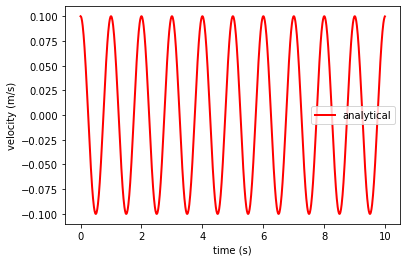

In [40]:
import matplotlib.pyplot as plt

# Young's modulus
E = 4 * (np.pi)**2

# analytical solution
ta, va, xa = analytical_vibration(E = E, rho = 1, v0 = 0.1, x_loc = 1.0, duration = 10, dt = 0.01, L = 1.0)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

#### 1D MPM code

In [41]:
# Computational grid
L          = 1                       # domain size
nodes      = np.array([0, L])        # nodal coordinates
nnodes     = len(nodes)              # number of nodes
nelements  = 1                       # number of elements
nparticles = 1                       # number of particles
el_length  = L / nelements           # element length

# Initial conditions 
v0         = 0.1                     # initial velocity
x_loc      = 1.0                     # location to get analytical solution

# Material points
x_p        = 0.5 * el_length         # particle position
mass_p     = 1.                      # particle mass
vol_p      = el_length / nparticles  # particle volume
vel_p      = v0                      # particle velocity
stress_p   = 0.                      # particle stress
mv_p       = mass_p * vel_p          # particle momentum = m * v

# Material property
E          = 4 * (np.pi)**2          # Young's modulus
rho        = 1.                      # Density

# Time
duration   = 10
dt         = 0.01
time       = 0
nsteps     = int(duration/dt)

# Store time, velocity and position with time
time_t, vel_t, x_t = [], [], []

for _ in range(nsteps):
    # shape function and derivative
    N  = np.array([1 - abs(x_p - nodes[0])/L, 1 - abs(x_p - nodes[1])/L])
    dN = np.array([-1/L, 1/L])

    # map particle mass and momentum to nodes
    mass_n = N * mass_p
    mv_n   = N * mv_p
    
    # apply boundary condition: velocity at left node is zero
    mv_n[0] = 0

    # compute internal force at node
    f_int_n = - vol_p * stress_p * dN

    # external force at node
    f_ext_n = 0

    # total force at node
    f_total_n = f_int_n + f_ext_n

    # apply boundary condition: left node has no acceleration (f = m * a, and a = 0)
    f_total_n[0] = 0

    # update nodal momentum
    mv_n += f_total_n * dt

    # update particle position and velocity
    for i in range(nnodes):
        vel_p += dt * N[i] * f_total_n[i] / mass_n[i]
        x_p += dt * N[i] * mv_n[i] / mass_n[i]

    # update particle momentum
    mv_p = mass_p * vel_p

    # map nodal velocity
    vel_n = mass_p * vel_p * np.divide(N, mass_n)
    # Apply boundary condition and set left nodal velocity to zero
    vel_n[0] = 0

    # compute strain rate at the particle
    # strain_rate = dN[0] * vel_n[0] + dN[1] * vel_n[1]
    strain_rate_p = np.dot(dN, vel_n) 
    # compute strain increament 
    dstrain_p = strain_rate_p * dt
    # compute stress
    stress_p += E * dstrain_p

    # store properties for plotting
    time_t.append(time)
    vel_t.append(vel_p)
    x_t.append(x_p)
    
    # update time
    time += dt


> plot results of MPM and analytical solution

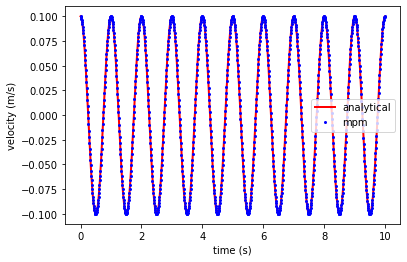

In [42]:
import matplotlib.pyplot as plt

ta, va, xa = analytical_vibration(E, rho, v0, x_loc, duration, dt, L)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')
plt.plot(time_t, vel_t, 'ob', markersize = 2, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()